# TP auto-regressive image completion

Save the notebook as either PDF or HTML and make sure all the results are saved correctly (I won't run them and the original format does not save the results automatically), **and put your name in the filename**.

<div class="alert alert-success"> 
<b>Questions are in green boxes.</b>
The maximum time you should spend on each question is given as indication only. If you take more time than that, then you should come see me.
</div>
<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

In [1]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
from einops import rearrange

For this lab, we will use the bluebell dataset. It consists of $64\times 64$ color images, which we will have to flatten into $12k$ dimensional vectors. The code for the dataset comes with several train/val/test splits.

0


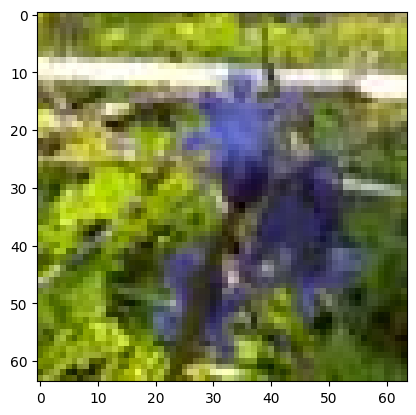

In [2]:
# Load the dataset
from bluebell import Bluebell
X_train_ds = Bluebell('bluebell_64', 'train', split=0)
X_val_ds = Bluebell('bluebell_64', 'val', split=0)
X_train = np.array([img.flatten()/127.5 - 1. for img, lab in X_train_ds])
y_train = np.array([lab for img, lab in X_train_ds])
X_val = np.array([img.flatten()/127.5 - 1. for img, lab in X_val_ds])
y_val = np.array([lab for img, lab in X_val_ds])
plt.imshow(X_train[0].reshape(64, 64, 3)/2+0.5)
print(y_train[0])

## Image tokenization

First, we want to transform the image into a sequence of discrete tokens to ease the prediction process. Predicting the $(r,g,b)$ triplet value of each pixels is too cumbersome, so instead we are going to patchify the image into a sequence of $4\times 4$ pixels and then quantize these patches with a dictionary so that we obtain a sequence of integer. Combining those process is called _tokenization_

The main appeal of tokenization is that it transforms the problem of pixel prediction into a classification problem: what is the index of the next token? This problem is much simpler to solve than the original (vector) regression problem.

We first write the 2 functions to transform an image into a sequence of patches and vice-versa.

In [3]:
def image_to_patches(X, k=4):
    X = rearrange(X, 'b (h w c) -> b h w c', h=64, w=64, c=3)
    X = rearrange(X, 'b (h m) (w n) c -> b (h w) (m n c)', m=k, n=k)
    return X

def patches_to_image(X, k=4):
    X = rearrange(X, 'b (h w) (m n c) -> b (h m) (w n) c', m=k, n=k, h=64//k, w=64//k)
    return X


In [4]:
X = image_to_patches(X_train)
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X is {X.shape}")
Y = patches_to_image(X)
print(Y.shape)


The shape of X_train is (1200, 12288)
The shape of X is (1200, 256, 48)
(1200, 64, 64, 3)


Then, we want to create a dictionary of patches such that each patch can be replace by the integer corresponding to its closest match from the dictionary. To that end, we will use K-Means, thanks to sk-learn.


<div class="alert alert-success"> 
<b>Q1. Train a k-means clustering algorithm on the training set converted to sequences of patches.</b>
Then, create quantized version of the training and validation set called Xq_train and Xq_val respectively. Reconstruct some of the training images and compare them to the original images. For now on, we will consider only 16 clusters due to speed consideration, at the cost of degraded visual quality, but we can always go back to bigger dictionaries later. (should run in less than 3 minutes)
</div>

In [5]:
n_clusters = 16

In [6]:
Xp_train = image_to_patches(X_train)
Xp_val = image_to_patches(X_val)
print(f"Xp_train's shape is: {Xp_train.shape}")
print(f"Xp_val's shape is: {Xp_val.shape}")

Xp_train_patches = Xp_train.reshape(Xp_train.shape[0]*Xp_train.shape[1], 48)
Xp_val_patches = Xp_val.reshape(Xp_val.shape[0]*Xp_val.shape[1], 48)
print(f"Xp_train_patches' shape is {Xp_train_patches.shape}")
print(f"Xp_val_patches' shape is {Xp_val_patches.shape}")

Xp_train's shape is: (1200, 256, 48)
Xp_val's shape is: (300, 256, 48)
Xp_train_patches' shape is (307200, 48)
Xp_val_patches' shape is (76800, 48)


In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(Xp_train_patches)

KMeans(n_clusters=16)

(1200, 256)
(300, 256)


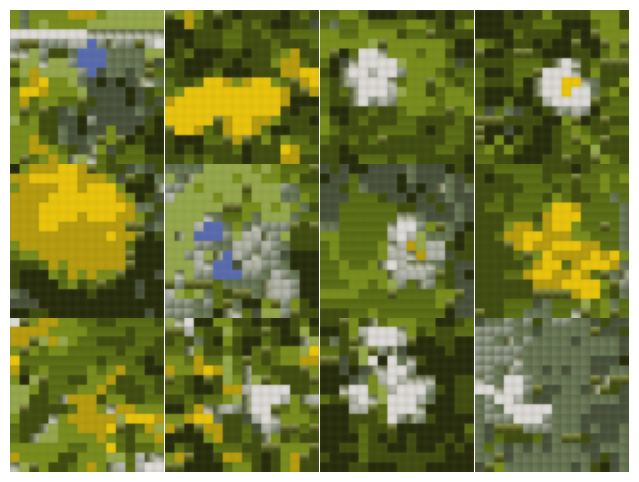

In [8]:
# Xq_train
num_samples_train, patches_train, d = Xp_train.shape
Xq_train = kmeans.predict(Xp_train_patches).reshape(num_samples_train, patches_train)
print(Xq_train.shape)

#Xq_val
num_samples_val, patches_val, d = Xp_val.shape
Xq_val = kmeans.predict(Xp_val_patches).reshape(num_samples_val, patches_val)
print(Xq_val.shape)


def reconstruct_from_tokens(X_quantized, centroids):
    patches = centroids[X_quantized]  # shape: (N, 256, 48)
    imgs = patches_to_image(patches)  # shape: (N, 64, 64, 3)
    imgs = (imgs + 1.0) / 2.0
    return imgs


centroids = kmeans.cluster_centers_
imgs_train = reconstruct_from_tokens(Xq_train, centroids)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
# Remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(12):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.imshow(imgs_train[i])
    ax.axis("off")

plt.show()


<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

### Linear model

We first consider a linear model over the past $k$ tokens, of the form

$$ f(x_{n-k}, ..., x_n) = W_o^\top \sum_j \alpha_m W_i[x_{n-m}] + \beta[y] $$

with $x_n$ the token at location $n$ taken in raster scan order and $y$ the class associated with the image. In this model, we first transform the token $x_n$ into a vector thanks to an embedding matrix $W_i$ (which can be done in matrix product with a one-hot encoding of $x_n$). We also transform the class of the image $y$ into the same feature space with another embedding matrix $\beta$. Then, we compute a weighted sum of those features thanks to parameters $\alpha$. Finally, we predict the class of the next token with the linear classifier $W_o$.

To train this model, we need a classification loss. We can use the categorical cross-entropy, which is well suited as the targets are exclusive: 

$$ \min -x_n\log (f(x_{n-k-1}, ..., x_{n-1})[x_n]) $$

which can be computed with jnn.log_softmax.

<div class="alert alert-success"> 
<b>Q2. in the following ARPredictor class, write the pred function.</b>
Notice that the parameters are provided in a dictionary as created in the constructor of the class. Since the model is linear, everything can be done with some matmuls, sums and swapaxes. Run your method on some images, just to make sure all sizes are correct and in the right order. (indicative time, should run in less than a second after compiling).
</div>

In [9]:
k = 128

In [10]:
class ARPredictor():
    def __init__(self, k, dim, n_clusters):
        self.k = k
        self.dim = dim
        self.n_clusters = n_clusters
        self.params = {
            "w_in": np.random.randn(n_clusters, dim)/(dim+n_clusters),
            "alpha": np.random.randn(k),
            "beta": np.random.randn(12, dim),
            "w_out": np.zeros((dim, n_clusters)), #np.random.randn(dim, n_clusters)/np.sqrt(dim+n_clusters),
            "b_out": -np.ones(n_clusters) * np.log(n_clusters)
        }

    def predict(self, X, z):
        return ARPredictor.pred(self.params, jnn.one_hot(X, self.n_clusters), jnn.one_hot(z, 12))

    @staticmethod
    @jax.jit
    # X probably of shape (batch_size, k, 16)
    # y probably of shape (batch_size, 12)
    def pred(params, X, z):
        w_in         = params["w_in"]    # (cluster_size, dim)
        alpha        = params["alpha"]   # (k,)
        beta         = params["beta"]    # (num_classes, dim)
        w_out        = params["w_out"]   # (dim, cluster_size)
        b_out        = params["b_out"]   # (cluster_size,)

        # 2. Forward pass
        X_emb        = X @ w_in                               # (Batch, k, dim)
        weighted     = (X_emb * alpha[None, :, None]).sum(axis=1)  # (Batch, dim)
        z_emb        = z @ beta                               # (Batch, dim)
        h            = weighted + z_emb                       # (Batch, dim)
        logits       = h @ w_out + b_out                      # (Batch, cluster_size)
        return logits

    @staticmethod
    @jax.jit
    def xe(params, X, y, z):
        y_pred = ARPredictor.pred(params, X, z)
        l = -(jnn.log_softmax(y_pred)*y).sum(axis=-1).mean()
        return l

    @staticmethod
    @jax.jit
    def update(params, X, y, z, eta=0.01):
        l, g = jax.value_and_grad(ARPredictor.xe, argnums=(0))(params, X, y, z)
        for k in params.keys():
            #print(f"{k}: {params[k]} g: {g[k]}")
            params[k] = params[k] - eta * g[k]
        return l, params
    
    def fit(self, X, y, n_iter=1000, batch_size=256, eta=0.01):
        sequence_length = X.shape[1]
        losses = []

        for step in range(n_iter):
            # --- sample random batch and timestep ---
            batch_indices = np.random.randint(0, X.shape[0], size=batch_size)
            t = np.random.randint(0, sequence_length - self.k - 1)

            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            # --- extract context and target tokens ---
            X_context = jnn.one_hot(X_batch[:, t : t + self.k], self.n_clusters)   # (Batch, k, cluster_size)
            X_target  = jnn.one_hot(X_batch[:, t + self.k],     self.n_clusters)   # (Batch, cluster_size)
            z_input   = jnn.one_hot(y_batch, 12)                                   # (Batch, num_classes)

            # --- update model parameters ---
            loss, self.params = ARPredictor.update(self.params, X_context, X_target, z_input, eta=eta)
            losses.append(float(loss))

            if step % 100 == 0:
                print(f"[{step}] Loss: {loss:.4f}")

        # --- plot training curve ---
        plt.plot(losses)
        plt.title("Training Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Cross-Entropy")
        plt.tight_layout()
        plt.show()

        return losses

    # X_init of shape k 

    def gen_ar(self, X_init, z, km, seed=3407):
        # X_init : (batch, k)  – integer tokens
        X   = jnp.array(X_init, dtype=jnp.int32)
        key = jax.random.PRNGKey(seed)

        for _ in range(256 - X.shape[1]):
            # last-k context (left-pad with 0 if sequence still < k)
            ctx = X[:, -self.k:]
            ctx = jnp.pad(ctx, ((0, 0), (self.k - ctx.shape[1], 0)))

            logits = self.pred(self.params, jnn.one_hot(ctx, self.n_clusters), z)
            key, sub = jax.random.split(key)
            next_tok = jax.random.categorical(sub, logits)          # (batch,)
            X = jnp.concatenate([X, next_tok[:, None]], axis=1)

        patches = km.cluster_centers_[np.array(X).ravel()]          # look-up on CPU
        patches = patches.reshape(X.shape[0], 256, -1)
        return patches_to_image(jnp.array(patches))


In [11]:
%%time
arp = ARPredictor(k, dim=64, n_clusters=n_clusters)

CPU times: total: 0 ns
Wall time: 275 μs


In [12]:
%%time
arp = ARPredictor(k, dim=64, n_clusters=n_clusters)

CPU times: total: 0 ns
Wall time: 297 μs



<div class="alert alert-success"> 
<b>Q3. Write the generation method.</b>
The generation method (gen_ar) takes as argument the start of a sequence and their class and generates the rest of the sequence. It thus loops over the missing tokens and calls the predict method with the last $k$ elements of the sequence. This returns a set of logits from which we have to sample a class (ie, the index in the dictionary of the next token). We can do this using the jax.random.categorial function which is why there is a seed in the argument of the function. Last, the sequence of indices is converted back to an image and returned. (generating should take less than 30 seconds). Run it on a just initialized model. You should get complete random patterns after the begining of the image.
</div>

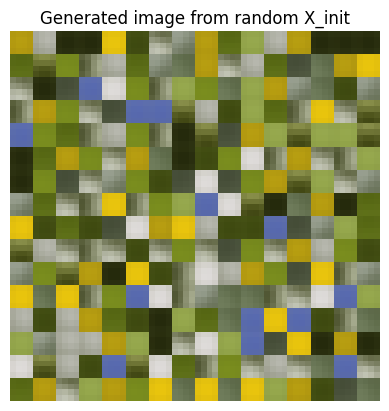

In [13]:
# ---- model --------------------------------------------------------------
dim = 60
model = ARPredictor(k=k, dim=dim, n_clusters=n_clusters)

# ---- seed sequence + label ---------------------------------------------
X_init = np.random.randint(0, n_clusters, size=(1, k))   # (1, k)  ← extra axis
z_int  = np.random.randint(0, 12, size=(1,))             # (1,)    ← extra axis
z_one  = jax.nn.one_hot(z_int, 12)                       # (1, 12)

# ---- generate -----------------------------------------------------------
img = model.gen_ar(X_init, z_one, kmeans)   # (1, 64, 64, 3)
img = (img + 1) / 2                         # [-1,1] → [0,1]

# ---- visualise ----------------------------------------------------------
plt.imshow(np.clip(np.array(img[0]), 0, 1))
plt.axis('off')
plt.title("Generated image from random X_init")
plt.show()


<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>


<div class="alert alert-success"> 
<b>Q4. Write the fit method.</b>
To train the model, we will perform SGD. We randomly sample mini-batches from X, randomly sample a timestep $t$ to crop the sequence between $t$ and $t+k-1$ and try to predict the value at $t+k$. We do this for a number of iterations and store the updates parameters in the model. We plot the loss value to verify that the loss decreases on average. Then, we generate a few image starting from the begining of Xq_val to check that we have something that is less random than the model at initialization.
</div>

In [14]:
print(Xq_val.shape)
print(y_val.shape)

(300, 256)
(300,)


[0] Loss: 2.7726
[100] Loss: 2.5927
[200] Loss: 2.3316
[300] Loss: 2.2418
[400] Loss: 2.3329
[500] Loss: 2.0605
[600] Loss: 2.4426
[700] Loss: 2.3662
[800] Loss: 2.2511
[900] Loss: 2.1489


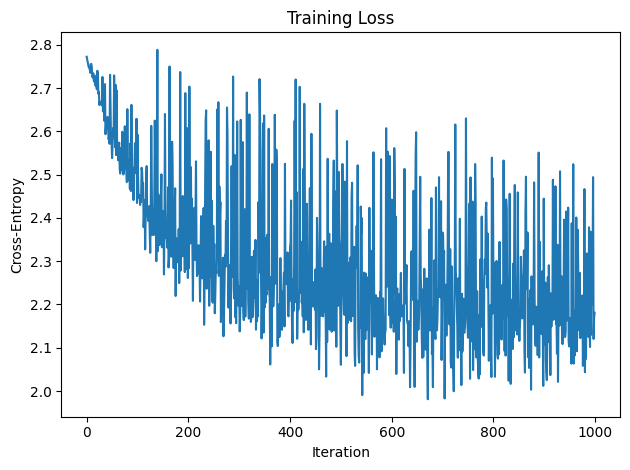

In [15]:
model = ARPredictor(k, dim=64, n_clusters=16)
losses = model.fit(Xq_val, y_val, n_iter=1000, batch_size=256, eta=0.01)


In [16]:
print(model.k)

128


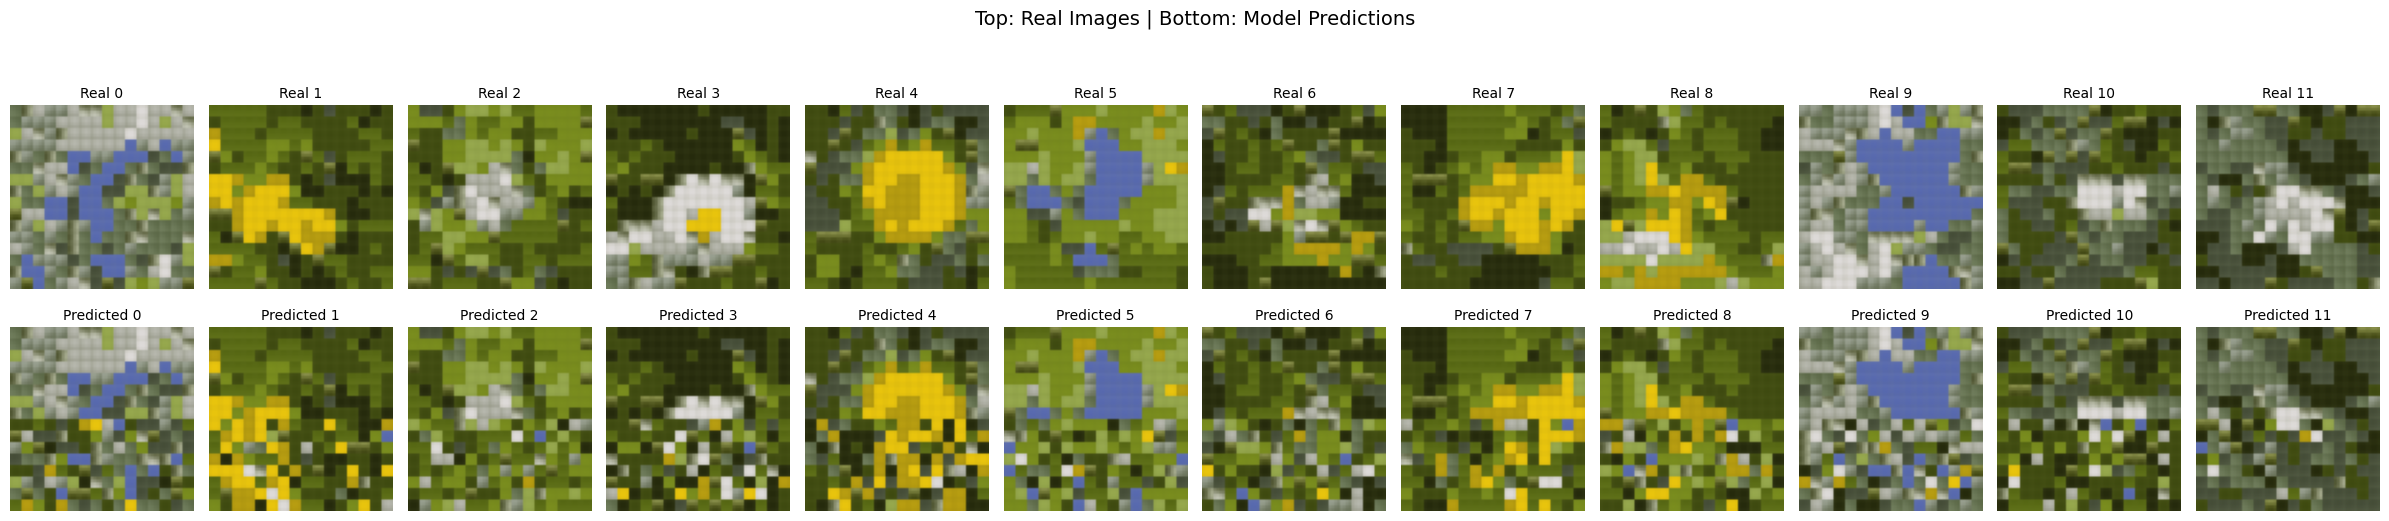

In [17]:

# ------------------------------------------------------------
# 1.  Grab the first 12 sequences and their labels
# ------------------------------------------------------------
n_show = 12
X_seed  = Xq_val[:n_show, :k]                 # (12, k)
z_seed  = jnn.one_hot(y_val[:n_show], 12)     # (12, 12)

# ------------------------------------------------------------
# 2.  Generate complete sequences with the model
#     (gen_ar returns images already scaled to [-1, 1])
# ------------------------------------------------------------
generated_imgs = model.gen_ar(X_seed, z_seed, kmeans)      # (12, 64, 64, 3)
generated_imgs = (generated_imgs + 1) / 2                  # → [0, 1]

# ------------------------------------------------------------
# 3.  Reconstruct the real validation images
# ------------------------------------------------------------
real_imgs = reconstruct_from_tokens(Xq_val[:n_show], kmeans.cluster_centers_)  # (12, 64, 64, 3)

# ------------------------------------------------------------
# 4.  Plot: real on top, generated underneath
# ------------------------------------------------------------
fig, axes = plt.subplots(2, n_show, figsize=(n_show * 2, 5))

for i in range(n_show):
    # Real image
    axes[0, i].imshow(np.clip(real_imgs[i], 0, 1))
    axes[0, i].set_title(f"Real {i}", fontsize=10)
    axes[0, i].axis("off")

    # Predicted image
    axes[1, i].imshow(np.clip(generated_imgs[i], 0, 1))
    axes[1, i].set_title(f"Predicted {i}", fontsize=10)
    axes[1, i].axis("off")

# Adjust layout
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.suptitle("Top: Real Images | Bottom: Model Predictions", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()




<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>


<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

### Transformers

We now want to consider a more capable model: the transformer.

Transformers are built around masked softmax attention, which combines tokens using weights from a normalized dot-product. Given 3 projection $W_q, W_k$ and $W_v$, we have

$$ Q = XW_q, K = XW_k, V = XW_v, $$
$$ A = \text{softmax}(QK^\top/\sqrt{d} - M), $$
$$ X \leftarrow X + AV, $$

with $M$ being a mask that contains 9999 on the lower triangular values, such that only previous tokens can be used in the combination (the softmax will output 0 for tokens with -9999).

Then, the block includes an MLP to process tokens one by one, with a single hidden layer (weights $W_1, W_2$ and bias $b_1$:

$$ X \leftarrow X + \text{gelu}(XW_1 + b_1)W_2 $$


<div class="alert alert-success"> 
<b>Q5. Write the pred_method of the Transformer block</b>
All the parameters have been initialized in a dictionnary in the constructor. Check on a few samples that the dimensions and orders are correct.
</div>

In [18]:
class TransformerBlock():
    def __init__(self, hidden_dim=256):
        self.d = hidden_dim
        self.params = {
            "w_q": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
            "w_k": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
            "w_v": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
            "w_f1": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
            "b_f1": np.zeros((1, 1, hidden_dim)),
            "w_f2": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
        }

    @staticmethod
    @jax.jit
    def pred(params, X):

        """
        X: (batch, seq_len, d)
        returns: (batch, seq_len, d)
        """
        # Unpack weights
        w_q, w_k, w_v = params["w_q"], params["w_k"], params["w_v"]
        w1, b1, w2   = params["w_f1"], params["b_f1"], params["w_f2"]

        # 1) Project to queries, keys, values
        #    shapes: all (batch, seq_len, d)
        Q = X @ w_q
        K = X @ w_k
        V = X @ w_v

        # 2) Scaled dot-product
        d = X.shape[-1]
        scores = jnp.matmul(Q, jnp.swapaxes(K, 1, 2)) / jnp.sqrt(d)

        # 3) Causal mask: +1e9 on positions j>i
        seq_len = X.shape[1]
        mask = jnp.triu(jnp.ones((seq_len, seq_len)) * 1e9, k=1)
        scores = scores - mask[None, :, :]

        # 4) Attention weights + combine
        A = jax.nn.softmax(scores, axis=-1)           # (batch, seq_len, seq_len)
        X_att = X + jnp.matmul(A, V)                  # residual connection

        # 5) Feed-forward block
        H = jax.nn.gelu(X_att @ w1 + b1)              # (batch, seq_len, d)
        X_ff = X_att + (H @ w2)                       # second residual

        return X_ff


The full transformer model is then fairly simple: It starts by converting the indices of the input sequence into vectors using an embedding matrix. Because attention is equivariant, we need to keep track of the position of each token. Thus the positions of the tokens in the sequence are passed as a second argument and embedded using another matrix, then sumed to the token:

$$X = W_i[X] + W_p[P] $$.

Then we have several transformer blocks. Finally, we add a linear predictor on top, with its own weight $W_o$ and bias $b_o$. The whole model is trained using categorical cross-entropy.


<div class="alert alert-success"> 
<b>Q6. Write the pred method and the gen_ar method.</b>
The pred method can use the TransformerBlock.pred method. You should check it on a few samples to check that you get uniform logits after the initialization. The gen_ar method can be heavily inspired by that of the linear model (it requires the additional position instead of the class). Generate a few images that should look completely random.
</div>

In [ ]:

class Transformer():
    def __init__(self, input_dim, hidden_dim, n_layers, k, n):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.k = k
        self.n = n
        self.blocks = [TransformerBlock(hidden_dim) for _ in range(n_layers)]
        self.params = []
        self.params.append({ 
                            "w_i": np.random.randn(input_dim, hidden_dim)/np.sqrt(input_dim+hidden_dim),
                            "pos": np.random.randn(n, hidden_dim)/np.sqrt(n+hidden_dim)
                           })
        for i in range(n_layers):
            self.params.append(self.blocks[i].params)
        self.params.append({ "w_o": np.zeros((hidden_dim, input_dim)),
                             "b_o": -np.log(input_dim)*np.ones(input_dim)
                           })

    def predict(self, X, p):
        X = jnn.one_hot(X, self.input_dim)
        p = jnn.one_hot(p, self.n)
        return Transformer.pred(self.params, X, p)
    
    @staticmethod
    @jax.jit

    #in this function we predict the next token, X is of shape (batch_size, seq_length, input_dim), it takes a sequence like
    #[12,3,8,9,...] and they are one hot encoded, (0,0,...,1,0,0)
    #p is a one hot encoded vector of length (batch_size, seq_length, n) for example (1,3) will give a one hot encoded vector 
    #that represents the position of the third token
    def pred(params, X, p):

        # Embedding layer
        w_i = params[0]["w_i"]  # (input_dim, hidden_dim)
        w_p = params[0]["pos"]  # (n, hidden_dim)

        token_emb = jnp.einsum("bld,dh->blh", X, w_i)  # (B, L, H)
        pos_emb   = jnp.einsum("bld,dh->blh", p, w_p)  # (B, L, H)
        x = token_emb + pos_emb                        # (B, L, H)

        # Transformer blocks
        for block, block_params in zip(range(len(params[1:-1])), params[1:-1]):
            x = TransformerBlock.pred(block_params, x)

        # Output projection
        w_o = params[-1]["w_o"]  # (H, input_dim)
        b_o = params[-1]["b_o"]  # (input_dim,)
        logits = jnp.einsum("blh,hv->blv", x, w_o) + b_o

        return logits[:, -1, :]

    @staticmethod
    @jax.jit
    def xe(params, X, y, p):
        y_pred = Transformer.pred(params, X, p)
        # print(f"y_p: {y_pred.shape} y: {y.shape}")
        l = -(jnn.log_softmax(y_pred)*y).sum(axis=-1).mean()
        return l
    
    @staticmethod
    @jax.jit
    def update(params, X, y, z, pos, eta=0.01):
        l, g = jax.value_and_grad(Transformer.xe, argnums=(0))(params, X, y, pos)
        for i in range(len(g)):
            # print(f"l: {l} params: {params[i]} g: {g[i]}")
            for k in params[i].keys():
                params[i][k] = params[i][k] - eta * g[i][k]
        return l, params

    
    def fit(self, X, y, n_iter=1000, batch_size=256, eta=0.01):
        seq_len = X.shape[1]
        losses = []

        for it in range(n_iter):
            # Sample batch and time step
            idx = np.random.randint(0, X.shape[0], size=batch_size)
            t   = np.random.randint(0, seq_len - self.k - 1)

            Xb = X[idx]
            yb = Xb[:, t + self.k]  # target token at position t+k

            ctx = Xb[:, t : t + self.k]                          # context tokens
            pos = np.arange(t, t + self.k)[None, :]              # shape (1, k)
            pos = np.tile(pos, (batch_size, 1))                  # shape (B, k)

            X_input = jnn.one_hot(ctx, self.input_dim)           # (B, k, input_dim)
            P_input = jnn.one_hot(pos, self.n)                   # (B, k, n)
            Y_target = jnn.one_hot(yb, self.input_dim)           # (B, input_dim)

            # SGD update using existing update()
            loss, self.params = Transformer.update(self.params, X_input, Y_target, P_input, eta=eta)
            losses.append(float(loss))

            if it % 100 == 0:
                print(f"[{it}] loss: {loss:.4f}")

        # Plot training curve
        plt.plot(losses)
        plt.title("Transformer Training Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Cross-Entropy")
        plt.tight_layout()
        plt.show()

        return losses

 
        
        

    def gen_ar(self, X_init, km, seed=3407):
        pass
  

In [20]:
tr = Transformer(input_dim=n_clusters, hidden_dim=64, n_layers=4, k=k, n=256)

In [ ]:
# Configuration
input_dim = 16         # number of clusters (from KMeans)
hidden_dim = 64        # embedding dimension
n_layers = 2           # number of transformer blocks
k = 5                  # context window size
n = 256                # sequence length (fixed to 256 for image patches)
n_iter = 1000
batch_size = 256
learning_rate = 0.01

# Initialize transformer model
transformer = Transformer(input_dim=input_dim,
                          hidden_dim=hidden_dim,
                          n_layers=n_layers,
                          k=k,
                          n=n)

# Train on the training set
dummy_z = jnp.zeros((batch_size, 1))          # shape can be anything

loss, self.params = Transformer.update(
    self.params,
    X_input,          # X
    Y_target,         # y
    dummy_z,          # z  ←  placeholder
    P_input,          # pos
    eta=eta
)


TypeError: Transformer.update() missing 1 required positional argument: 'pos'

<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>


<div class="alert alert-success"> 
<b>Q7. Write the fit method.</b>
Then, train a model with a few layers as best as you can. Generate images and check that they are better than the initialization and maybe more coherent than the linear model.
</div>

x: (12, 128)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 281.97it/s]


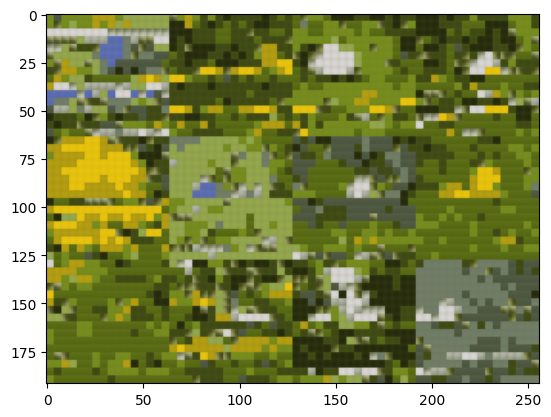


<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>


<div class="alert alert-warning" role="alert"><b>(Optional Q8. Improve visual quality)</b> Improve visual quality by increasing the size of the dictionary (try 256, 1024, 4096). The model will be harder to train, requiring better innitialization and longer training. The problem becomes also more complex and the transformer may need higher dimension and depths. Transformers can be unstable to train, you can normalize $Q$ and $K$ to avoid some problems. Decreasing the learning rate during training can also help. Having a bigger models will take vvery long to optimize...
</div>